In [ ]:
import  numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import time
import pandas as pd
from itertools import product
from sklearn.metrics import roc_auc_score
import scipy.io
import time
from sklearn.model_selection import train_test_split

import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/IA326/project')

## Algorithm

In [ ]:
class FISVDD():
  def __init__(self, data, sigma, eps_cp=1e-8, eps_ol=1e-8):
        self.data = data
        self.sigma = sigma
        self.eps_cp = eps_cp
        self.eps_ol = eps_ol

        self.inv_A = np.array([1])
        self.alpha = np.array([1])
        self.sv = np.array([self.data[0]])
        self.obj_val = []
        self.backup = []
        self.Q = 1
  def score_fcn(self, new_sv):

        dist_sq = np.linalg.norm(new_sv -  self.sv, axis = 1)
        cur_sim_vec = np.exp(-np.square(dist_sq) / (2.0 * self.sigma * self.sigma))
        m = max(cur_sim_vec)
        if m < self.eps_ol or m > 1 - self.eps_cp:
            res = -1
        else:
            res = self.Q - np.dot(self.alpha, cur_sim_vec)
        return res, cur_sim_vec


  def kernel(self, new_sv):


    dist = np.linalg.norm(new_sv- self.sv, axis = 1)

    return np.exp( -np.square(dist)/(2*self.sigma**2) )
  def increase_inv_A(self, v):
    p = np.dot(self.inv_A, v)
    beta = 1 - np.dot(v, p)

    t_a = len(self.inv_A)
    new_inv_A = np.ones((t_a + 1, t_a + 1))
    new_inv_A[ : t_a, : t_a] = self.inv_A + (1/beta) * np.outer(p, p)
    new_inv_A[: t_a, t_a] = - (1/beta)* p
    new_inv_A[ t_a, : t_a] = - (1/beta)* p
    new_inv_A[ t_a,  t_a] = 1/beta
    return new_inv_A
  def decrease_inv_A(self):
    k = len(self.inv_A) - 1
    P = self.inv_A[: k , : k ]
    u = self.inv_A[ : k, k]
    lambda_ = self.inv_A[k, k]
    new_inv_A = P - (1/lambda_)* np.outer(u, u)
    return new_inv_A
  def permutation(self, mat, ind):
    n = len(mat)
    perm = np.arange(n)
    perm[:ind] = np.arange(0, ind)
    perm[ind:n-1] = np.arange(ind+1, n)
    perm[n-1] = ind
    temp = mat[:, perm]
    perm_mat = temp[perm, :]
    return perm_mat

  def expand(self, new_sv, v):

    old_inv_A = self.inv_A
    self.inv_A = self.increase_inv_A(v)
    old_alpha = self.alpha
    self.alpha =  np.sum(self.inv_A, axis=1)
    if self.alpha[-1] <= 0 :
      self.inv_A = old_inv_A
      self.alpha = old_alpha
    else :
      self.sv = np.vstack((self.sv, new_sv))

  def shrink(self):
    flag = 1
    while flag == 1 :
      p = np.argmin(self.alpha)
      self.backup.append(self.sv[p])
      self.sv = np.concatenate((self.sv[:p], self.sv[p+1:]))
      self.inv_A = self.permutation(self.inv_A, p)
      self.inv_A = self.decrease_inv_A()
      self.alpha =  np.sum(self.inv_A, axis=1)
      if min(self.alpha) > 0 :
        flag = 0

  def train(self):
    for new_data in self.data[1:]:
      i = 1

      new_sv = np.array([new_data])
      Q, v = self.score_fcn(new_data)
      if Q <= 0 :
        pass
      else :
        self.expand(new_sv, v)
        if min(self.alpha) < 0 :
          self.backup = []
          self.shrink()
          if len(self.backup) > 1 :
            for j in range(len(self.backup)):
              Q, v = self.score_fcn(new_data)
              if Q > 0 :
                self.expand(self.backup[j], v)

              self.obj_val.append(self.Q)
        self.Q = 1 / sum(self.alpha)
        self.alpha = self.alpha/sum(self.alpha)

  def predict(self, X):
    y = np.zeros(len(X))
    for i in range(len(X)):
      res, _ = self.score_fcn(X[i])
      if res > 0 :
        y[i] =  1
      else:
        y[i] = 0
    return y




















## Training of hyperparamters


In [ ]:
import numpy as np
from itertools import product
from sklearn.metrics import roc_auc_score
def k_fold_cross_validation(X_t, y_t,params, k=5 ):
    indices_inliners = np.where(y_t == 0)[0]
    indices_outliners = np.where(y_t == 1)[0]
    X = X_t[indices_inliners]
    y = y_t[indices_inliners]
    n = len(X)
    fold_size = n // k
    indices = np.arange(n)

    best_score = -1
    best_params = None

    for param in params:

        mean_score = 0

        for i in range(k):
            validation_indices = indices[i * fold_size: (i + 1) * fold_size]

            train_indices = np.concatenate((indices[:i * fold_size], indices[(i + 1) * fold_size:]))


            X_train  = X[train_indices]
            X_val = np.vstack(( X[validation_indices],  X_t[indices_outliners]))
            y_train  = y[train_indices]
            y_val =  np.vstack(( y[validation_indices],  y_t[indices_outliners]))

            fd =  FISVDD(data= X_train, sigma= param)
            fd.train()
            score = roc_auc_score(y_val,  fd.predict(X_val))
            print(score)
            mean_score += score

        mean_score /= k
        print(mean_score)
        print('nb_support_vec : ', len(fd.sv))
        if mean_score > best_score:
            best_score = mean_score
            best_param = param

    return best_param, best_score


In [ ]:

def mean_criterion_method(data):
  N = len(data)
  row_variances = np.var(data, axis=0)
  sum_of_variances = np.sum(row_variances)
  delta = np.sqrt(2)* 10**(-6)
  sigma = np.sqrt(2* N*sum_of_variances/((N - 1)* np.log((N - 1)/delta**2)) )
  return sigma

## Features selection


# Experiments

In [ ]:
import scipy.io
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
data_sets = ['cover', 'mammography', 'satimage-2']
sigmas = []
train_obs = []
nb_features = []
roc_aux_scores =[]
times = []
sv = []
for data_set in data_sets :
  nom_fichier_mat = '/content/drive/MyDrive/IA326/project/' + data_set + '.mat'
  donnees = scipy.io.loadmat(nom_fichier_mat)
  indices_inliners = np.where(donnees['y'] == 0)[0]
  indices_outliners = np.where(donnees['y'] == 1)[0]
  sigma = sigma = mean_criterion_method(donnees['X'][indices_inliners])
  sigmas.append(sigma)
  X_train, X_test, y_train, y_test  = train_test_split(donnees['X'][indices_inliners] ,  donnees['y'][indices_inliners], test_size=1/5, random_state=42)
  obs, features = X_train.shape
  train_obs.append(obs)
  nb_features.append(features)
  debut = time.time()
  fd =  FISVDD(X_train, sigma = sigma)
  fd.train()
  X_test_  = np.vstack((X_test,  donnees['X'][indices_outliners]))
  y_test_ = np.vstack((y_test,  donnees['y'][indices_outliners]))
  fin = time.time()
  times.append(fin - debut)
  score = roc_auc_score(y_test_,  fd.predict(X_test_))
  roc_aux_scores.append(score)
  sv.append(len(fd.sv))
data = {'dataset ': data_sets,
        'sigma': sigmas,
        '#train obs': train_obs ,
        'nb_features ' : nb_features ,
        'AUROC' : roc_aux_scores,
        'time' : times,
        '#sv'  : sv  }

df = pd.DataFrame(data)


<ipython-input-4-59f045f0133e>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_inv_A[ t_a,  t_a] = 1/beta
<ipython-input-4-59f045f0133e>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_inv_A[ t_a,  t_a] = 1/beta
<ipython-input-4-59f045f0133e>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_inv_A[ t_a,  t_a] = 1/beta


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


data_sets = ['cover', 'mammography', 'satimage-2']
sigmas = []
train_obs = []
nb_features = [4, 2, 5]
roc_aux_scores =[]
times = []
sv = []
i = 0
for data_set in data_sets :

  nom_fichier_mat = '/content/drive/MyDrive/IA326/project/' + data_set + '.mat'
  donnees = scipy.io.loadmat(nom_fichier_mat)
  indices_inliners = np.where(donnees['y'] == 0)[0]
  indices_outliners = np.where(donnees['y'] == 1)[0]

  transformer = PCA(n_components= 'mle', svd_solver = 'full' )
  X_transformed = transformer.fit_transform(donnees['X'])
  sigma =  mean_criterion_method(X_transformed[indices_inliners])
  print(sigma)
  sigmas.append(sigma)
  X_train, X_test, y_train, y_test  = train_test_split(X_transformed[indices_inliners] ,  donnees['y'][indices_inliners], test_size=1/5, random_state=42)
  obs, features = X_train.shape
  train_obs.append(obs)

  debut = time.time()
  fd =  FISVDD(X_train, sigma = sigma)
  fd.train()
  X_test_  = np.vstack((X_test,  X_transformed[indices_outliners]))
  y_test_ = np.vstack((y_test,  donnees['y'][indices_outliners]))
  fin = time.time()
  times.append(fin - debut)
  score = roc_auc_score(y_test_,  fd.predict(X_test_))
  roc_aux_scores.append(score)
  sv.append(len(fd.sv))
  i+=1
data = {'dataset ': data_sets,
        'sigma': sigmas,
        '#train obs': train_obs ,
        'nb_features ' : nb_features ,
        'AUROC' : roc_aux_scores,
        'time' : times,
        '#sv'  : sv  }

df_pca = pd.DataFrame(data)

489.4091382291958


<ipython-input-3-59f045f0133e>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_inv_A[ t_a,  t_a] = 1/beta


0.4345464703511498


<ipython-input-3-59f045f0133e>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_inv_A[ t_a,  t_a] = 1/beta


20.730648854639163


<ipython-input-3-59f045f0133e>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_inv_A[ t_a,  t_a] = 1/beta


### Traditional SVDD

In [ ]:
from sklearn.svm import OneClassSVM


data_sets = ['cover', 'mammography', 'satimage-2']
sigmas = []
train_obs = []
nb_features = [4, 2, 5]
roc_aux_scores =[]
times = []
sv = []
i = 0
for data_set in data_sets :

  nom_fichier_mat = '/content/drive/MyDrive/IA326/project/' + data_set + '.mat'
  donnees = scipy.io.loadmat(nom_fichier_mat)
  indices_inliners = np.where(donnees['y'] == 0)[0]
  indices_outliners = np.where(donnees['y'] == 1)[0]
  X_train, X_test, y_train, y_test  = train_test_split(donnees['X'][indices_inliners] ,  donnees['y'][indices_inliners], test_size=1/5, random_state=42)
  sigma =  mean_criterion_method(donnees['X'][indices_inliners])
  obs, features = X_train.shape
  train_obs.append(obs)
  debut = time.time()
  clf = OneClassSVM(gamma= sigma, max_iter = 1000).fit(X_train)
  y_pred = clf.predict(X)
  X_test_  = np.vstack((X_test,  X_transformed[indices_outliners]))
  y_test_ = np.vstack((y_test,  donnees['y'][indices_outliners]))
  fin = time.time()
  times.append(fin - debut)
  score = roc_auc_score(y_test_,  clf.predict(X_test_))
  roc_aux_scores.append(score)
  i+=1
data = {'dataset ': data_sets,
        'sigma': sigmas,
        '#train obs': train_obs ,
        'nb_features ' : nb_features ,
        'AUROC' : roc_aux_scores,
        'time' : times
         }

df_ocsvm = pd.DataFrame(data)

## Auto-encoder OC-SVM

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
tf.set_random_seed(2018)


class AEOneClassSVM(object):

    def __init__(self, input_tensor, batch_size, name, autoencoder_layers, nu, alpha=1.0, sigma=1.0,
                 kernel_approx_features=1000, convolutional=False,
                 autoencoder_activation='linear',
                 ae_op=tf.train.AdamOptimizer(1e-2),
                 full_op=tf.train.AdamOptimizer(1e-2), svm_op=tf.train.AdamOptimizer(1e-4), seed=2018):
        self.input_tensor = input_tensor
        self.batch_size = batch_size
        self.name = name
        tf.set_random_seed(seed)
        self.seed = seed

        self.autoencoder_scope = '{}_autoencoder'.format(self.name)
        self.svm_scope = '{}_svm'.format(self.name)
        self.feature_analyser_scope = '{}_feature_analyser'.format(self.name)
        self.drop_rate = tf.placeholder_with_default(0.0, shape=())

        if autoencoder_activation == 'linear':
            self.autoencoder_activation = lambda x: tf.add(x, 0.0)
        elif autoencoder_activation == 'sigmoid':
            self.autoencoder_activation = lambda x: tf.sigmoid(x)
        elif autoencoder_activation == 'tanh':
            self.autoencoder_activation = lambda x: tf.tanh(x)
        elif autoencoder_activation == 'relu':
            self.autoencoder_activation = lambda x: tf.nn.relu(x)
        else:
            raise Exception()

        if convolutional:
            self.encoded, self.decoded = self._create_cae()
            self.bottleneck_size = self.encoded.get_shape().as_list()[1]
            self.reconstruction_loss = tf.reduce_mean(tf.pow(self.decoded - self.input_tensor, 2))
        else:
            if autoencoder_layers is not None:
                self.bottleneck_size = autoencoder_layers[-1]
                self.encoded = self._create_encoder(self.input_tensor, autoencoder_layers)
                self.decoded = self._create_decoder(autoencoder_layers[::-1], self.input_tensor)
                self.reconstruction_loss = tf.reduce_mean(tf.pow(self.decoded - self.input_tensor, 2))
            else:
                self.encoded = input_tensor
                self.bottleneck_size = input_tensor.get_shape().as_list()[1]
                self.reconstruction_loss = 0

        self.alpha = alpha
        self.sigma = sigma
        self.nu = nu
        self.kernel_approx_features = kernel_approx_features
        (self.output, self.svm_loss, self.svm_weights,
         self.svm_rho, self.margin, self.rff_x) = self._create_ocsvm()

        self.gradient = tf.gradients(self.margin, self.input_tensor, name='gradient')
        self.input_x_gradient = tf.multiply(self.gradient, self.input_tensor, name='input_x_gradient')
        self.gradient_percent = tf.divide(self.input_x_gradient, tf.reduce_sum(self.input_x_gradient),
                                          name='gradient_percent')

        self.loss = self.alpha * self.reconstruction_loss + self.svm_loss
        full_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, '{}|{}'.format(self.autoencoder_scope,
                                                                                       self.svm_scope))
        self.full_optimizer = full_op.minimize(self.loss, var_list=full_vars)

        if self.reconstruction_loss != 0:
            self.ae_optimizer = ae_op.minimize(
                self.reconstruction_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                                                     self.autoencoder_scope))
        self.svm_optimizer = svm_op.minimize(
            self.svm_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.svm_scope))

    def fit(self, sess, train_data, epochs_1, epochs_2, input_tensor=None, shuffle=False, verbose=False,
            validation_data=None, validation_label=None):
        input_tensor = input_tensor if input_tensor is not None else self.input_tensor
        batches = int(len(train_data) / self.batch_size)

        data = train_data

        print('Combined train')
        for i in range(epochs_1):
            if shuffle:
                data = sk_shuffle(train_data, random_state=self.seed)
            for b in range(batches):
                batch_data = data[b * self.batch_size:(b + 1) * self.batch_size]
                sess.run([self.full_optimizer, self.loss], feed_dict={input_tensor: batch_data, self.drop_rate: 0.5})
            epoch_loss = sess.run(self.loss, feed_dict={input_tensor: train_data}) / len(train_data)
            epoch_loss_ae = sess.run(self.reconstruction_loss, feed_dict={input_tensor: train_data}) / len(train_data)
            epoch_loss_svm = sess.run(self.svm_loss, feed_dict={input_tensor: train_data}) / len(train_data)
            if verbose:
                predictions = self.predict(sess, validation_data)
                print('Epoch:', i + 1, 'Loss:', epoch_loss, '(', epoch_loss_ae, 'x', self.alpha, '+', epoch_loss_svm, ')',
                      'AUROC:', roc_auc_score(-validation_label, -predictions),
                      'AUPRC:', average_precision_score(-validation_label, -predictions))
            else:
                print('.', end='')

        print('SVM train')
        for i in range(epochs_2):
            if shuffle:
                data = sk_shuffle(train_data, random_state=self.seed)
            for b in range(batches):
                batch_data = data[b * self.batch_size:(b + 1) * self.batch_size]
                sess.run([self.svm_optimizer, self.svm_loss], feed_dict={input_tensor: batch_data})
            epoch_loss = sess.run(self.loss, feed_dict={input_tensor: train_data}) / len(train_data)
            epoch_loss_ae = sess.run(self.reconstruction_loss, feed_dict={input_tensor: train_data}) / len(train_data)
            epoch_loss_svm = sess.run(self.svm_loss, feed_dict={input_tensor: train_data}) / len(train_data)
            if verbose:
                predictions = self.predict(sess, validation_data)
                print('Epoch:', i + 1, 'Loss:', epoch_loss, '(', epoch_loss_ae, 'x', self.alpha, '+', epoch_loss_svm, ')',
                      'AUROC:', roc_auc_score(-validation_label, -predictions),
                      'AUPRC:', average_precision_score(-validation_label, -predictions))
            else:
                print('.', end='')


    def fit_ae(self, sess, train_data, epochs, input_tensor=None, shuffle=False, verbose=False):
        input_tensor = input_tensor if input_tensor is not None else self.input_tensor
        batches = int(len(train_data) / self.batch_size)

        data = train_data

        print('Autoencoder train')
        for i in range(epochs):
            if shuffle:
                data = sk_shuffle(train_data, random_state=self.seed)
            for b in range(batches):
                batch_data = data[b * self.batch_size:(b + 1) * self.batch_size]
                sess.run([self.ae_optimizer, self.reconstruction_loss], feed_dict={input_tensor: batch_data, self.drop_rate: 0.5})
            if verbose:
                epoch_loss = sess.run(self.reconstruction_loss, feed_dict={input_tensor: train_data}) / len(train_data)
                print('Epoch:', i + 1, 'Loss:', epoch_loss)
            else:
                print('.', end='')

    def fit_svm(self, sess, train_data, epochs, input_tensor=None, shuffle=False,
                verbose=False, validation_data=None, validation_label=None):
        input_tensor = input_tensor if input_tensor is not None else self.input_tensor
        batches = int(len(train_data) / self.batch_size)

        data = train_data

        print('SVM train')
        for i in range(epochs):
            if shuffle:
                data = sk_shuffle(train_data, random_state=self.seed)
            for b in range(batches):
                batch_data = data[b * self.batch_size:(b + 1) * self.batch_size]
                sess.run([self.svm_optimizer, self.svm_loss], feed_dict={input_tensor: batch_data})
            epoch_loss = sess.run(self.loss, feed_dict={input_tensor: train_data}) / len(train_data)
            epoch_loss_svm = sess.run(self.svm_loss, feed_dict={input_tensor: train_data}) / len(train_data)
            if verbose:
                predictions = sess.run(self.output, feed_dict={input_tensor: validation_data})
                print('Epoch:', i + 1, 'Loss:', epoch_loss_svm,
                      'AUROC:', roc_auc_score(validation_label, predictions),
                      'AUPRC:', average_precision_score(-validation_label, -predictions)
                     )

    def predict(self, sess, data):
        pred = sess.run(self.output, feed_dict={self.input_tensor: data}).T[0]

        return np.array([p if p != 0 else 1 for p in pred]).T

    def decision_function(self, sess, data):
        return sess.run(self.margin, feed_dict={self.input_tensor: data})

    def encode(self, sess, data):
        return sess.run(self.encoded, feed_dict={self.input_tensor: data})

    def encode_rff(self, sess, data):
        return sess.run(self.rff_x, feed_dict={self.input_tensor: data})

    def gradient(self, sess, data):
        return sess.run(self.gradient, feed_dict={self.input_tensor: data})

    def _create_encoder(self, x, hidden_nums):
        with tf.variable_scope(self.autoencoder_scope):
            layers = [None]*len(hidden_nums)

            init_bound = 4*np.sqrt(6. / (x.get_shape().as_list()[1] + hidden_nums[0]))
            w0 = tf.Variable(tf.random_uniform([x.get_shape().as_list()[1], hidden_nums[0]], -init_bound, init_bound))
            b0 = tf.Variable(tf.random_uniform([hidden_nums[0]], -0.1, 0.1))
            layers[0] = self.autoencoder_activation(tf.add(tf.matmul(x, w0), b0))

            if len(layers) > 1:
                for i in range(1, len(layers)):
                    init_bound = 4 * np.sqrt(6. / (hidden_nums[i-1] + hidden_nums[i]))
                    w = tf.Variable(tf.random_uniform([hidden_nums[i-1], hidden_nums[i]], -init_bound, init_bound))
                    b = tf.Variable(tf.random_uniform([hidden_nums[i]], -0.1, 0.1))
                    layers[i] = tf.convert_to_tensor(self.autoencoder_activation(tf.add(tf.matmul(layers[i-1], w), b)))

        return layers[-1]

    def _create_decoder(self, hidden_nums, ae_input):
        with tf.variable_scope(self.autoencoder_scope):
            layers = [None] * len(hidden_nums)

            if len(layers) > 1:
                init_bound = 4 * np.sqrt(6. / (hidden_nums[0] + hidden_nums[1]))
                w0 = tf.Variable(tf.random_uniform([hidden_nums[0], hidden_nums[1]], -init_bound, init_bound))
                b0 = tf.Variable(tf.random_uniform([hidden_nums[1]], -0.1, 0.1))
                layers[0] = self.autoencoder_activation(tf.add(tf.matmul(self.encoded, w0), b0))

                for i in range(1, len(hidden_nums) - 1):
                    init_bound = 4 * np.sqrt(6. / (hidden_nums[i] + hidden_nums[i + 1]))
                    w = tf.Variable(tf.random_uniform([hidden_nums[i], hidden_nums[i + 1]], -init_bound, init_bound))
                    b = tf.Variable(tf.random_uniform([hidden_nums[i + 1]], -0.1, 0.1))
                    layers[i] = self.autoencoder_activation(tf.add(tf.matmul(layers[i - 1], w), b))

            output_dim = ae_input.get_shape().as_list()[1]
            w_out = tf.Variable(tf.truncated_normal([hidden_nums[-1], output_dim]))
            b_out = tf.Variable(tf.truncated_normal([output_dim]))
            if len(layers) > 1:
                layers[-1] = self.autoencoder_activation(tf.add(tf.matmul(layers[-2], w_out), b_out))
            else:
                layers[-1] = self.autoencoder_activation(tf.add(tf.matmul(self.encoded, w_out), b_out))

        return layers[-1]

    def _create_ocsvm(self):
        with tf.variable_scope(self.svm_scope):
            np.random.seed(self.seed)
            omega_matrix_shape = [self.bottleneck_size, self.kernel_approx_features]

            omega_matrix = tf.constant(
                np.random.normal(
                    scale=1.0 / self.sigma, size=omega_matrix_shape),
                dtype=tf.float32)
            omega_x = tf.matmul(self.encoded, omega_matrix)
            cos_omega_x = tf.cos(omega_x)
            sin_omega_x = tf.sin(omega_x)
            x = tf.sqrt(1.0 / self.kernel_approx_features) * tf.concat([cos_omega_x, sin_omega_x], 1)

            features = x.get_shape().as_list()[1]
            w = tf.Variable(tf.truncated_normal([features, 1]))
            rho = tf.Variable(0.0, tf.float32)

            n_margin = tf.subtract(rho, tf.matmul(x, w), name='{}_margin'.format(self.name))

            reg_loss = 0.5*tf.reduce_sum(tf.square(w))
            hinge_loss = tf.reduce_mean(n_margin + tf.abs(n_margin))

            total_loss = tf.subtract(reg_loss, rho) + tf.divide(hinge_loss, self.nu)
            output = tf.sign(-n_margin, name='{}_output'.format(self.name))

            return output, total_loss, w, rho, -n_margin, x





def deconv2d(input, kshape, n_outputs, strides=[1, 1], activation=tf.nn.relu):
    out = tf.contrib.layers.conv2d_transpose(input,
                                             num_outputs= n_outputs,
                                             kernel_size=kshape,
                                             stride=strides,
                                             padding='SAME',
                                             #weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                                             #biases_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                             activation_fn=activation)
    return out


#   ---------------------------------
def maxpool2d(x, kshape=[1, 2, 2, 1], strides=[1, 2, 2, 1]):
    out = tf.nn.max_pool(x,
                         ksize=kshape, #size of window
                         strides=strides,
                         padding='SAME')
    return out




In [ ]:
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
def load_dataset(data_set, random_state=1):


    nom_fichier_mat = '/content/drive/MyDrive/IA326/project/' + data_set + '.mat'
    donnees = scipy.io.loadmat(nom_fichier_mat)
    x = MinMaxScaler().fit_transform(donnees['X'])
    y = donnees['y']
    y = np.array([1 if l == 0 else -1  for l in y])

    normal = x[np.where(y == 1)]
    anomalies = x[np.where(y == -1)]

    x = np.concatenate((normal, anomalies), axis=0)
    y = np.concatenate(([1]*len(normal), [-1]*len(anomalies)), axis=0)
    x, y = shuffle(x, y, random_state=random_state)

    normal = x[np.where(y == 1)]
    test_normal = normal[int(len(normal)/2):]
    normal = normal[:int(len(normal)/2)]

    anomalies = x[np.where(y == -1)]
    test_anomalies = anomalies[int(len(anomalies)/2):]
    anomalies = anomalies[:int(len(anomalies)/2)]

    x_train = np.concatenate((normal, anomalies), axis=0)
    y_train = np.concatenate(([1]*len(normal), [-1]*len(anomalies)), axis=0)
    x_train, y_train = shuffle(x_train, y_train, random_state=1)

    x_test = np.concatenate((test_normal, test_anomalies), axis=0)
    y_test = np.concatenate(([1]*len(test_normal), [-1]*len(test_anomalies)), axis=0)
    x_test, y_test = shuffle(x_test, y_test, random_state=1)

    return x_train, y_train, x_test, y_test

In [ ]:
 x_train, y_train, x_test, y_test = load_dataset('cover', random_state=1)

(286048,)


In [ ]:
x_test.shape

(143025, 10)

In [ ]:
from pprint import pprint

data_sets = ['cover', 'mammography', 'satimage-2']
sigmas = []
train_obs = []
nb_features = []
roc_aux_scores =[]
times = []

i = 0
for data_set in data_sets :


  X_train, X_test, y_train, y_test  = load_dataset(data_set, random_state=1)
  print(X_train.shape)
  sigma =  mean_criterion_method(X_train)
  obs, features = X_train.shape
  train_obs.append(obs)
  nb_features.append(features)
  debut = time.time()
  nu = 0.3
  alpha = 1e3
  sigma = mean_criterion_method(X_train)
  kernel_features = 1000
  autoencoder_layers = [features, 32, 16]
  batch_size = 1024
  data_input = tf.placeholder(tf.float32, shape=[None, features])

  ae1svm = AEOneClassSVM(data_input, batch_size, 'ae1svm', autoencoder_layers[1:], nu, alpha, sigma, kernel_features,
                       autoencoder_activation='sigmoid', seed=4,
                       full_op=tf.train.AdamOptimizer(1e-2),
                       svm_op=tf.train.AdamOptimizer(1e-4))
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Autoencoder-OneclassSVM
    t0 = time.time()
    ae1svm.fit(sess, X_train, epochs_1=10, epochs_2=5)
    print('Train time:', time.time() - t0)

    t0 = time.time()
    print(X_tes.shape)
    out_y = ae1svm.predict(sess, X_test)
    print('Test time:', time.time() - t0)

    pprint(metrics(y_test, out_y))
    score = roc_auc_score(y_test,  out_y)
    roc_aux_scores.append(score)

  fin = time.time()
  times.append(fin - debut)

  i+=1
data = {'dataset ': data_sets,
        'sigma': sigmas,
        '#train obs': train_obs ,
        'nb_features ' : nb_features ,
        'AUROC' : roc_aux_scores,
        'time' : times
         }

df_ae = pd.DataFrame(data)

(143025, 10)
Combined train
.......SVM train
.....Train time: 161.87735533714294
(143025, 10)
Test time: 4.336160898208618
0.7426940494842496
(5592, 6)
Combined train
.......SVM train
.....Train time: 7.582283020019531
(5592, 6)
Test time: 0.22756123542785645
0.5329760865278991
(2902, 36)
Combined train
.......SVM train
.....Train time: 2.9734573364257812
(2902, 36)
Test time: 0.13617897033691406
0.6568291075443902


In [ ]:
from collections import Counter
from pprint import pprint
tf.set_random_seed(2018)

x_train, y_train, x_test, y_test = forestcover(random_state=1)

counter = Counter(y_train)
print('Anomalies ratio:', 100*counter[-1]/(counter[1]+counter[-1]), '%')

(286048, 10)
(286048,)
Anomalies ratio: 0.959985456884557 %


In [ ]:
counter = Counter(y_train)
print('Anomalies ratio:', 100*counter[-1]/(counter[1]+counter[-1]), '%')

Anomalies ratio: 0.959985456884557 %


In [ ]:
autoencoder_layers = [10, 32, 16]
batch_size = 1024

nu = 0.3
alpha = 1e3
sigma = mean_criterion_method(x_train)
kernel_features = 1000

data_input = tf.placeholder(tf.float32, shape=[None, 10])

ae1svm = AEOneClassSVM(data_input, batch_size, 'ae1svm', autoencoder_layers[1:], nu, alpha, sigma, kernel_features,
                       autoencoder_activation='sigmoid', seed=4,
                       full_op=tf.train.AdamOptimizer(1e-2),
                       svm_op=tf.train.AdamOptimizer(1e-4))

ae_only = AEOneClassSVM(data_input, batch_size, 'ae_only', autoencoder_layers[1:], nu, alpha, sigma, kernel_features,
                        autoencoder_activation='sigmoid', ae_op=tf.train.AdamOptimizer(1e-2))

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Autoencoder-OneclassSVM
    t0 = time.time()
    ae1svm.fit(sess, x_train, epochs_1=10, epochs_2=5)
    print('Train time:', time.time() - t0)

    t0 = time.time()
    out_y = ae1svm.predict(sess, x_test)
    print('Test time:', time.time() - t0)

    pprint(metrics(y_test, out_y))

Combined train
..........SVM train
.....Train time: 106.83877611160278
Test time: 2.4190311431884766
{'AUPRC': 0.022923401654179665,
 'AUROC': 0.6933281637916967,
 'Confusion matrix': array([[   727,    647],
       [ 20179, 121472]]),
 'F1': 0.06526032315978456,
 'Precision': 0.03477470582607864,
 'Recall': 0.5291120815138283}


In [ ]:
autoencoder_layers = [54, 32, 16]
batch_size = 1024
data_set = 'cover'

nom_fichier_mat = '/content/drive/MyDrive/IA326/project/' + data_set + '.mat'
donnees = scipy.io.loadmat(nom_fichier_mat)
nu = 0.3
alpha = 1e3
sigma = 3
#mean_criterion_method(donnees['X'])
kernel_features = 200

data_input = tf.placeholder(tf.float32, shape=[None, 54])

ae1svm = AEOneClassSVM(data_input, batch_size, 'ae1svm', autoencoder_layers[1:], nu, alpha, sigma, kernel_features,
                       autoencoder_activation='sigmoid', seed=4,
                       full_op=tf.train.AdamOptimizer(1e-2),
                       svm_op=tf.train.AdamOptimizer(1e-4))

In [ ]:
from sklearn.utils import shuffle
def data_load(data_set, random_state=1):


    x = donnees['X']
    y = donnees['y']
    indices_inliners = np.where(y == 0)[0]
    indices_outliners = np.where(y == 1)[0]
    normal = x[indices_inliners]
    anomalies = x[indices_outliners]
    print(normal.shape)
    x = np.vstack((normal, anomalies))
    print(2)
    y  = np.concatenate(([1]*len(normal), [-1]*len(anomalies)), axis=0)
    print(3)
    x, y = shuffle(x, y, random_state=random_state)

    normal = x[np.where(y == 1)]
    test_normal = normal[int(len(normal)/2):]
    normal = normal[:int(len(normal)/2)]

    anomalies = x[np.where(y == -1)]
    test_anomalies = anomalies[int(len(anomalies)/2):]
    anomalies = anomalies[:int(len(anomalies)/2)]

    x_train = np.vstack((normal, anomalies))
    y_train = np.concatenate(([1]*len(normal), [-1]*len(anomalies)), axis = 0)
    x_train, y_train = shuffle(x_train, y_train, random_state=1)

    x_test = np.vstack((test_normal, test_anomalies))
    y_test = np.concatenate(([1]*len(test_normal), [-1]*len(test_anomalies)), axis = 0)
    x_test, y_test = shuffle(x_test, y_test, random_state=1)

    return x_train, y_train, x_test, y_test

In [ ]:
y = donnees['y']
y[indices_inliners] = 1
y[indices_outliners] = -1

<ipython-input-98-ad27ce8843b9>:3: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  y[indices_outliners] = -1


In [ ]:
y

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)

In [ ]:
import time
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Autoencoder-OneclassSVM
    data_set = 'cover'
    t0 = time.time()
    nom_fichier_mat = '/content/drive/MyDrive/IA326/project/' + data_set + '.mat'
    donnees = scipy.io.loadmat(nom_fichier_mat)
    indices_inliners = np.where(donnees['y'] == 0)[0]
    indices_outliners = np.where(donnees['y'] == 1)[0]

    X_train, X_test, y_train, y_test  = x_train, y_train, x_test, y_test
    print(X_train.shape)
    print(X_test.shape)
    ae1svm.fit(sess, x_train, epochs_1=7, epochs_2=0)
    print('Train time:', time.time() - t0)

    t0 = time.time()
    out_y = ae1svm.predict(sess, x_test)
    print('Test time:', time.time() - t0)
    pprint(metrics(y_test, out_y))

(143023, 54)
(143025, 54)
Combined train
.......SVM train
Train time: 15.85056734085083
Test time: 0.8240368366241455
{'AUPRC': 0.014770963022783523,
 'AUROC': 0.6042925276185437,
 'Confusion matrix': array([[   461,    913],
       [ 17980, 123671]]),
 'F1': 0.04653040625788544,
 'Precision': 0.024998644325145057,
 'Recall': 0.33551673944687044}


In [ ]:
 len(np.where(y_test == -1)[0])

1374

In [ ]:
len(indices_outliners)

2747

In [ ]:
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
def forestcover(data_set, random_state=1):


    x = donnees['X']
    print(x.shape)
    x = MinMaxScaler().fit_transform(x)
    y = donnees['y']
    y = np.array([1 if l == 0 else -1  for l in y])
    print(y.shape)
    normal = x[np.where(y == 1)]
    anomalies = x[np.where(y == -1)]

    x = np.concatenate((normal, anomalies), axis=0)
    y = np.concatenate(([1]*len(normal), [-1]*len(anomalies)), axis=0)
    x, y = shuffle(x, y, random_state=random_state)

    normal = x[np.where(y == 1)]
    test_normal = normal[int(len(normal)/2):]
    normal = normal[:int(len(normal)/2)]

    anomalies = x[np.where(y == -1)]
    test_anomalies = anomalies[int(len(anomalies)/2):]
    anomalies = anomalies[:int(len(anomalies)/2)]

    x_train = np.concatenate((normal, anomalies), axis=0)
    y_train = np.concatenate(([1]*len(normal), [-1]*len(anomalies)), axis=0)
    x_train, y_train = shuffle(x_train, y_train, random_state=1)

    x_test = np.concatenate((test_normal, test_anomalies), axis=0)
    y_test = np.concatenate(([1]*len(test_normal), [-1]*len(test_anomalies)), axis=0)
    x_test, y_test = shuffle(x_test, y_test, random_state=1)

    return x_train, y_train, x_test, y_test

In [ ]:
 x_train, y_train, x_test, y_test = forestcover('cover', random_state=1)

NameError: name 'donnees' is not defined

In [ ]:
x_train.shape

(143023, 54)

In [ ]:
from pprint import pprint

autoencoder_layers = [54, 32, 16]
batch_size = 1024

nu = 0.3
alpha = 1e3
sigma = 3.0
kernel_features = 200


tf.compat.v1.disable_eager_execution()
data_input = tf.compat.v1.placeholder(tf.float32, shape=[None, 54])

ae1svm = AEOneClassSVM(data_input, batch_size, 'ae1svm', autoencoder_layers[1:], nu, alpha, sigma, kernel_features,
                       autoencoder_activation='sigmoid', seed=4,
                       full_op=tf.optimizers.Adam(1e-2),
                       svm_op=tf.optimizers.Adam(1e-4))




ValueError: `tape` is required when a `Tensor` loss is passed. Received: loss=Tensor("add_2:0", shape=(), dtype=float32), tape=None.

In [ ]:
print(latex_table)

\begin{tabular}{llrrrrrr}
\toprule
{} &     dataset  &       sigma &  \#train obs &  nb\_features  &     AUROC &       time &  \#sv \\
\midrule
0 &        cover &  489.409138 &      226640 &             4 &  0.934185 &  32.317753 &  277 \\
1 &  mammography &    0.434546 &        8738 &             2 &  0.681297 &   2.074640 &  160 \\
2 &   satimage-2 &   20.730649 &        4585 &             5 &  0.869353 &   4.054209 &  421 \\
\bottomrule
\end{tabular}



$\begin{tabular}{llrrrrrr}
\toprule
{} &     dataset  &       sigma &  \#train obs &  nb\_features  &     AUROC &       time &   \#sv \\
\midrule
0 &        cover &  490.215556 &      226640 &            10 &  0.934546 &  42.158550 &   389 \\
1 &  mammography &    0.546081 &        8738 &             6 &  0.764623 &   3.828233 &   611 \\
2 &   satimage-2 &   21.321185 &        4585 &            36 &  0.780892 &  11.981400 &  1002 \\
\bottomrule
\end{tabular}$

In [ ]:
import scipy.io

# Charger le fichier .mat
nom_fichier_mat = '/content/drive/MyDrive/IA326/project/satimage-2.mat'
donnees = scipy.io.loadmat(nom_fichier_mat)


In [ ]:
from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=10, kernel='rbf', gamma= sigma)
X_transformed = transformer.fit_transform(donnees['X'])

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
X_transformed.shape

(5803, 7)

In [ ]:
donnees['X'].shape

(3686, 400)

In [ ]:
def rule_of_thumb_silverman(data):
    s = (data.shape[1] * (data.shape[0] + 2) / 4.0) ** (-1.0 / (data.shape[0] + 4.0))
    return 1 / (2 * s ** 2)

In [ ]:
l = rule_of_thumb_silverman(donnees['X'])

In [ ]:
1/(l**2)

3.9992460703815973

In [ ]:
l

0.5000471272632497

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

transformer = PCA( n_components = 5)
X_std = sc.transform(donnees['X'])
X_transformed = transformer.fit_transform(X_std)
X_transformed.shape

(5803, 5)

In [ ]:
def rff_gaussian(input_dim, d, X, gamma = 1.0):
  omega= np.random.normal(size=(input_dim, d), scale = np.sqrt(2*gamma))
  b = np.random.uniform(0, 2 * np.pi, size=(1, d))
  return np.sqrt(2 / d) * np.cos(X @ omega + b)


In [ ]:
x_rff = rff_gaussian(10,  20, donnees['X'], gamma= 420)

In [ ]:
x_rff.shape

(286048, 20)

In [ ]:
len(donnees['X'])

286048

In [ ]:
donnees['X'][indices_outliners].shape

(2747, 10)

In [ ]:
indices_inliners = np.where(donnees['y'] == 0)[0]
indices_outliners = np.where(donnees['y'] == 1)[0]

In [ ]:
len(indices_inliners)

283301

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(donnees['X'][indices_inliners] ,  donnees['y'][indices_inliners], test_size=1/5, random_state=42)
fd =  FISVDD(X_train, sigma = sigma)
fd.train()


<ipython-input-4-59f045f0133e>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_inv_A[ t_a,  t_a] = 1/beta


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(x_rff[indices_inliners] ,  donnees['y'][indices_inliners], test_size=1/5, random_state=42)
fd =  FISVDD_rff(X_train)
fd.train()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X_transformed[indices_inliners] ,  donnees['y'][indices_inliners], test_size=1/5, random_state=42)
fd =  FISVDD(X_train, sigma= sigma)
fd.train()

<ipython-input-4-59f045f0133e>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_inv_A[ t_a,  t_a] = 1/beta


In [ ]:
fd.obj_val

[0.17063592041068368,
 0.17063592041068368,
 0.10205576931898316,
 0.10205576931898316,
 0.08871411032078429,
 0.08871411032078429,
 0.07441070409839741,
 0.07441070409839741,
 0.06335855748071355,
 0.06335855748071355,
 0.055202997543871146,
 0.055202997543871146,
 0.04978463554955426,
 0.04978463554955426,
 0.04978463554955426,
 0.04978463554955426,
 0.04857518270529986,
 0.04857518270529986,
 0.04857518270529986,
 0.04649670401784925,
 0.04649670401784925,
 0.04459816987674711,
 0.04459816987674711,
 0.04440423978636459,
 0.04440423978636459,
 0.04395970257272001,
 0.04395970257272001,
 0.04238944806282918,
 0.04238944806282918,
 0.04238944806282918,
 0.04238944806282918,
 0.041128948230864174,
 0.041128948230864174,
 0.040869520882662755,
 0.040869520882662755,
 0.037344406980837845,
 0.037344406980837845,
 0.0364397685882296,
 0.0364397685882296,
 0.036146241710428066,
 0.036146241710428066,
 0.03444065667328152,
 0.03444065667328152,
 0.03414124080688895,
 0.03414124080688895,
 0

In [ ]:
fd =  FISVDD(X_train, sigma = 869)
fd.train()

<ipython-input-4-59f045f0133e>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_inv_A[ t_a,  t_a] = 1/beta


KeyboardInterrupt: 

In [ ]:
len(fd.sv)

223

In [ ]:
X_test_  = np.vstack((X_test,  donnees['X'][indices_outliners]))
y_test_ = np.vstack((y_test,  donnees['y'][indices_outliners]))

In [ ]:
X_test_  = np.vstack((X_test,  X_transformed[indices_outliners]))
y_test_ = np.vstack((y_test,  donnees['y'][indices_outliners]))

In [ ]:
len(X_test_)

59408

In [ ]:
def predict(A):
  y = np.zeros(len(A))
  for i in range(len(A)):

    if fd.predict(A[i]) > 0 :
      y[i] =  1
    else:
      y[i] = 0
  return y

In [ ]:
print(predict(X_test_))

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_,  fd.predict(X_test_))

0.528169014084507

In [ ]:
X_test_  = np.vstack((X_test,  x_rff[indices_outliners]))
y_test_ = np.vstack((y_test,  donnees['y'][indices_outliners]))

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_,  fd.predict(X_test_))

0.9345369117952075

Features selection


In [ ]:
reduce_training_set(donnees['X'], 100)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


IndexError: index 2179 is out of bounds for axis 0 with size 100

In [ ]:
def normalized_data(data):

    data_norm = (data - data.mean(numeric_only=True)) / data.std(numeric_only=True)
    return data_norm

def dist_euclidian(data):



    # Convertir las columnas del dataframe en una matriz NumPy
    data_mat = data

    # Calcular las distancias euclidianas entre cada par de puntos
    dist = np.sqrt(np.sum((data_mat[:, np.newaxis, :] - data_mat[np.newaxis, :, :]) ** 2, axis=-1))

    return dist, data_mat

def delete_Neighbor(data):
    # Calcular la matriz de distancias euclidianas
    dist, data_mat = dist_euclidian(data)

    # Encontrar el índice del punto con la distancia euclidiana más corta
    min_index = np.unravel_index(np.argmin(dist), dist.shape)

    # Eliminar la fila y columna correspondientes al punto con la distancia euclidiana más corta
    data_mat = np.delete(data_mat, min_index[0], axis=0)
    data_mat = np.delete(data_mat, min_index[1], axis=1)

    return data_mat

In [ ]:
data_mat =  delete_Neighbor(donnees['X'])

In [ ]:
donnees['X'].shape

(11183, 6)

In [ ]:
data_mat.shape

(11182, 5)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma=420).fit(X_train)

In [ ]:
y_pred = clf.predict(X_test_)

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_,  y_pred)

0.5

In [ ]:
len(np.where(y_pred == -1)[0])

59408

In [ ]:
len(indices_outliners)

2747

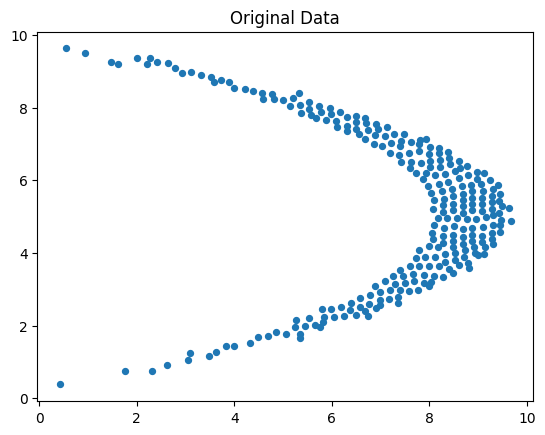

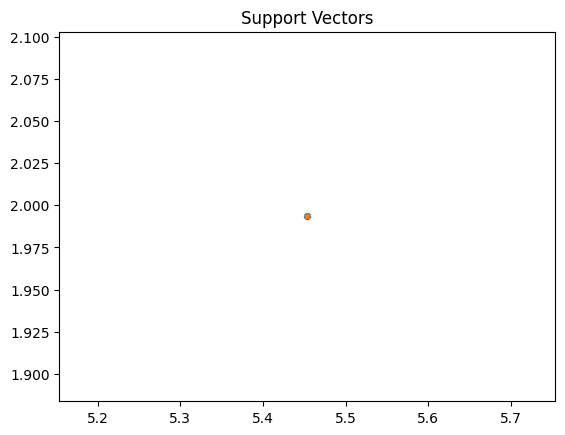

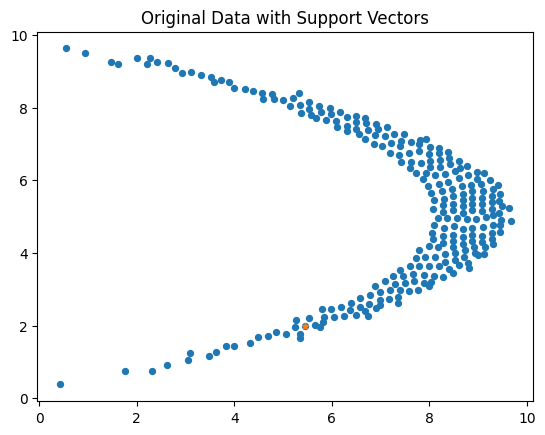

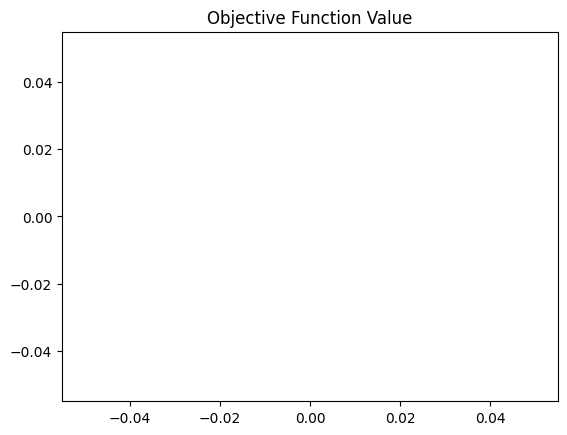

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/IA326/project/sample_input.csv", header=0)
data = np.array(data)


s = 0.8 # initialization with a random number between 0~1


#################
#  plot result  #
#################
plt.scatter(data[:, 0], data[:, 1], s=18)
plt.title('Original Data')
plt.savefig('original_data', dpi=300)
plt.show()
plt.scatter(fd.sv[:, 0], fd.sv[:, 1], s=18)
plt.scatter(fd.sv[:, 0], fd.sv[:, 1], marker='*', s=18)
plt.title('Support Vectors')
plt.savefig('support_vectors', dpi=300)
plt.show()
plt.scatter(data[:, 0], data[:, 1], s=18)
plt.scatter(fd.sv[:, 0], fd.sv[:, 1], marker='*', s=18)
plt.title('Original Data with Support Vectors')
plt.savefig('final_result', dpi=300)
plt.show()
plt.plot(fd.obj_val)
plt.title('Objective Function Value')
plt.savefig('obv', dpi=300)
plt.show()

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/IA326/project/sample_input.csv", header=0)
data = np.array(data)
data_rff = rff_gaussian(len(data[0]),  200, data, gamma= 0.8)

fd =  FISVDD_rff(data)
fd.train()


In [ ]:
fd.predict(np.array([6, 2]))

-0.0015183258752389378

array([1.])

In [ ]:
data  = np.random.normal(size = (100,2))

In [ ]:
data[14]

array([-0.0768116 , -0.83032229])

In [ ]:
data[14] = np.array([-4, 6])
data[32] = np.array([9, -4])
data[56] = np.array([7, 3])

In [ ]:
fd = FISVDD(data, 1)

In [ ]:
fd.train()

Q =  -1
Q =  -1
Q =  -1
Q =  -1
Q =  -1
Q =  -1
